## Titanic3
- 생존자 예측 모델 개발을 위한 분석 셋

In [1794]:
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
from numpy import random as npr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc
rc('font', family='Malgun Gothic')      #한글 폰트설정
plt.rcParams['axes.unicode_minus']=False      #마이너스 부호 출력 설정

### 과제
: 타이타닉 생존자 예측모델 개발을 위한 전처리 및 통계적 시각적 탐색을 통하여 최적의 분석용 데이터셋을 작성하세요.

#### Titanic data 전처리
- 분석 데이터 : titanic3.csv
- 재사용 가능한 전처리 사용자 함수 작성 하여 전처리
    - Null 값 처리 : Age는 평균나이, 나머지 칼럼은 'N'값으로 변경
    - 불필요한 속성 칼럼 삭제
    - 문자열 칼럼 레이블 인코딩
- 통계적, 시각적 탐색을 통한 다양한 인사이트 도출
- 탐색적 분석을 통한 feature engineering, 파생변수 

#### 컬럼 정보

- survived : 생존여부(1: 생존, 0 : 사망)
- pclass : 승선권 클래스(1 : 1st, 2 : 2nd ,3 : 3rd)
- name : 승객 이름
- sex : 승객 성별
- age : 승객 나이
- sibsp : 동반한 형제자매, 배우자 수
- parch : 동반한 부모, 자식 수
- ticket : 티켓의 고유 넘버
- fare 티켓의 요금
- cabin : 객실 번호
- embarked : 승선한 항구명(C : Cherbourg, Q : Queenstown, S : Southampton)
- boat
- body
- home.dest

In [1795]:
df = pd.read_csv('../dataset/titanic3.csv',encoding='euc-kr')

# 분석용 데이터 셋
df.to_pickle('../dataset/tt3.pkl')
df = pd.read_pickle('../dataset/tt3.pkl')

In [1796]:
df.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

In [1797]:
#### fare열 결측치 해당 객실 등급의 평균 가격으로 치환
df['fare'].replace(np.nan, 999999,inplace=True)
idx = df['fare']==999999
df['pclass'][idx]     #3등급 객실

idx2 = (df['pclass']==3) & (df['fare']!=999999)
df['fare'][idx]=df['fare'][idx2].mean()

In [1798]:
df.fare.describe()

count    1309.000000
mean       33.280206
std        51.741830
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: fare, dtype: float64

In [1799]:
df = df.drop(['body','ticket', 'home.dest','boat'], axis=1)
# body, ticket, home.dest, boat 열 삭제  (home.dest는 369개 중 214개가 전부 다른 값이므로 사용이 어려워보임)

df['family'] = df['sibsp'] + df['parch']      # 동승한 가족들 수

In [1800]:
#### 항구: 가장 많이 나온 값으로 변경
mvalue = df['embarked'].value_counts(dropna=True).idxmax()
df['embarked'].fillna(mvalue, inplace=True)

In [1801]:
df.tail()

,pclass,survived,name,sex,age,sibsp,parch,fare,cabin,embarked,family
1304,3,0,"Zabour, Miss. Hileni",female,14.5,1,0,14.4542,NaN,C,1
1305,3,0,"Zabour, Miss. Thamine",female,NaN,1,0,14.4542,NaN,C,1
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5,0,0,7.2250,NaN,C,0
1307,3,0,"Zakarian, Mr. Ortin",male,27.0,0,0,7.2250,NaN,C,0
1308,3,0,"Zimmerman, Mr. Leo",male,29.0,0,0,7.8750,NaN,S,0


In [1802]:
#### name에서 직업/타이틀 뽑아내기
def get_j(x):
    a = x.split(', ')
    b = a[1].split('.')
    cat = b[0]
    return cat

df['name_j'] = df.name.apply(lambda x: get_j(x))

In [1803]:
df.name_j.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Ms                2
Major             2
Capt              1
Sir               1
Dona              1
Jonkheer          1
the Countess      1
Don               1
Mme               1
Lady              1
Name: name_j, dtype: int64

In [1804]:
idx = (df['name_j']!='Mr') & (df['name_j']!='Miss') & (df['name_j']!='Mrs') & (df['name_j']!='Master') & (df['name_j']!='Rev') & (df['name_j']!='Dr')
df['name_j'][idx]='Other'
# df.head()

In [1805]:
#### 이름 구분 -> 나이 nan처리
df['age'].replace(np.nan, 1000, inplace=True)
ix = df['age']!=1000
ix2 = df['age']==1000
ix3 = df['sex']=='female'
ix4 = df['sex']=='male'

idx1 = df['name'].str.contains('Miss. ')   #미혼 여성
idx2 = df['name'].str.contains('Mrs. ')    #기혼 여성
idx3 = df['name'].str.contains('Dr. ')     #의사
idx4 = df['name'].str.contains('Master. ') #남자
idx6 = df['name'].str.contains('Mr. ')     #남자
idx7 = df['name'].str.contains('Ms. ')     #여자

miss = df['age'][idx1&ix].mean()
mrs = df['age'][idx2&ix].mean()
dr1 = df['age'][idx3&ix&ix3].mean()
dr2 = df['age'][idx3&ix&ix4].mean()
master = df['age'][idx4&ix].mean()
mr = df['age'][idx6&ix].mean()
ms = df['age'][idx7&ix].mean()

df['age'][idx1&ix2] = miss
df['age'][idx2&ix2] = mrs
df['age'][idx3&ix2&ix3] = dr1
df['age'][idx3&ix2&ix4] = dr2
df['age'][idx4&ix2] = master
df['age'][idx6&ix2] = mr
df['age'][idx7&ix2] = ms

In [1806]:
df = df.drop(['name'], axis=1)

<AxesSubplot:ylabel='Frequency'>

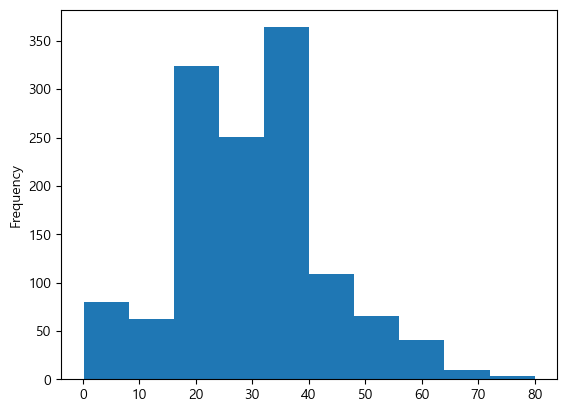

In [1807]:
df.age.plot(kind='hist')

In [1808]:
df.fare.describe()

count    1309.000000
mean       33.280206
std        51.741830
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: fare, dtype: float64

<AxesSubplot:ylabel='Frequency'>

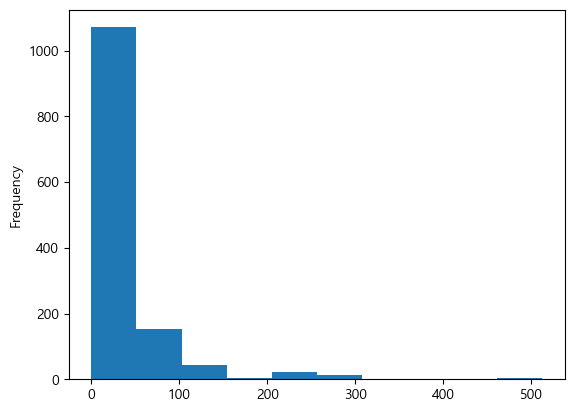

In [1809]:
df.fare.plot(kind='hist')

In [1810]:
#### 가격 범주화
def get_cate(fare):
    cat=''
    if fare<=15: cat='저가'
    elif fare<=60: cat='중가'
    elif fare<=200: cat='고가'
    else: cat='프리미엄'
    return cat

df['fare_cat']=df.fare.apply(lambda x: get_cate(x))
df.fare_cat.value_counts()

저가      674
중가      451
고가      146
프리미엄     38
Name: fare_cat, dtype: int64

In [1811]:
#### 나이 범주화
def get_age(age):
    cat = ''
    if age < 5: cat='Baby'
    elif age < 15: cat= 'Child'
    elif age < 21: cat= 'Young Adult'
    elif age < 49: cat='Adult'
    elif age < 70: cat='Old'
    else: cat = 'Elder'
    return cat

df['age_cat'] = df.age.apply(lambda x: get_age(x))

In [1812]:
#### 객실 구역 나누기
df['cabin'].replace(np.nan, 'X', inplace=True)
idx1 = df['cabin'].str.contains('A')
idx2 = df['cabin'].str.contains('B')
idx3 = df['cabin'].str.contains('C')
idx4 = df['cabin'].str.contains('D')
idx5 = df['cabin'].str.contains('E')
idx6 = df['cabin'].str.contains('F')
idx7 = df['cabin'].str.contains('G')

df['cabin'][idx1] = 'A'
df['cabin'][idx2] = 'B'
df['cabin'][idx3] = 'C'
df['cabin'][idx4] = 'D'
df['cabin'][idx5] = 'E'
df['cabin'][idx6] = 'F'
df['cabin'][idx7] = 'G'

In [1813]:
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,family,name_j,fare_cat,age_cat
0,1,1,female,29.00,0,0,211.3375,B,S,0,Miss,프리미엄,Adult
1,1,1,male,0.92,1,2,151.5500,C,S,3,Master,고가,Baby
2,1,0,female,2.00,1,2,151.5500,C,S,3,Miss,고가,Baby
3,1,0,male,30.00,1,2,151.5500,C,S,3,Mr,고가,Adult
4,1,0,female,25.00,1,2,151.5500,C,S,3,Mrs,고가,Adult


### 나이대에 따른 생존률

<AxesSubplot:xlabel='age_cat', ylabel='survived'>

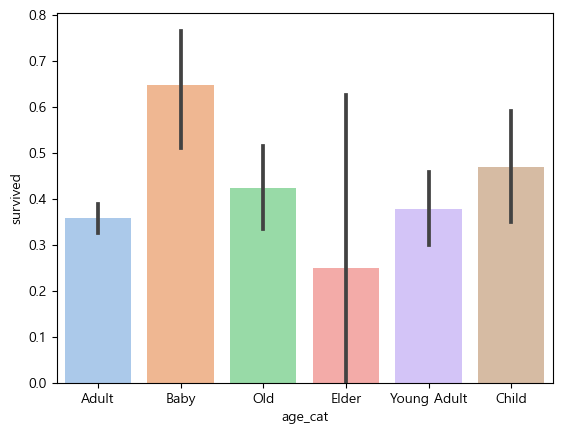

In [1831]:
sns.barplot(x='age_cat',y='survived',data=df, palette='pastel')
# Elder는 1등급 승객조차도 절반밖에 못 살음 (다른 나이대 1등급에 비해 훨씬 낮은 수치)
# Elder의 23등급 전원 사망
# Old는 1등급 사람 비율이 워낙 많아서 생존률이 높게 나옴
# Old의 23등급 생존률만 떼어 놓고 보면 다른 그룹에 비해 낮은 편

<AxesSubplot:xlabel='age_cat', ylabel='survived'>

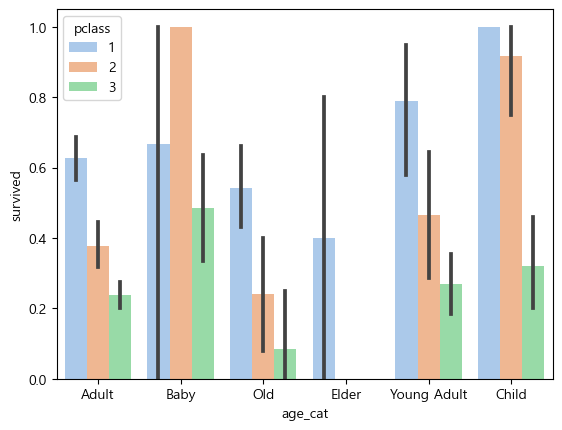

In [1829]:
sns.barplot(x='age_cat',y='survived',hue='pclass',data=df, palette='pastel')

<AxesSubplot:xlabel='age_cat', ylabel='count'>

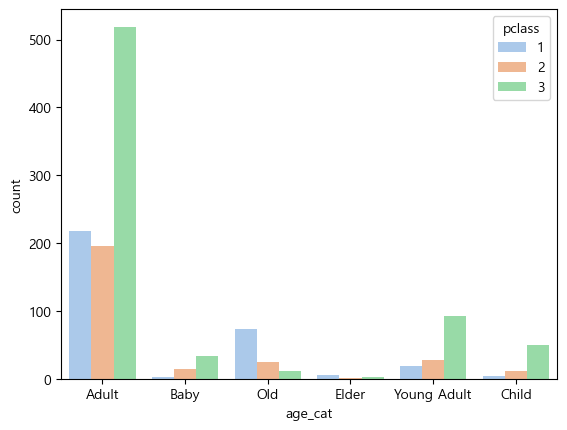

In [1830]:
sns.countplot(x='age_cat',hue='pclass',data=df, palette='pastel')

### 객실 구역에 따른 생존률

In [1774]:
df.cabin.value_counts()
# 알수 없음(X)값이 매우 많음

X    1014
C      94
B      65
D      46
E      41
A      22
F      17
G       9
T       1
Name: cabin, dtype: int64

In [1775]:
##### 객실별 pclass #####
a = df.groupby(['cabin','pclass']).agg({'pclass':'count', 'survived':'sum'})
a

# A,B,C는 1등급 객실만/ 그 외 나머지 객실도 거의 1,2,등급 사람들이 많음
# A~G까지, 등록되어 있는 객실 인원은 기본적으로 생존률이 매우 높은 편
# NAN값(X)은 거의다 3등급 사람들 -> 생존률 낮음

pclass  survived
cabin pclass                  
A     1           22        11
B     1           65        47
C     1           94        57
D     1           40        28
      2            6         4
E     1           34        24
      2            4         3
      3            3         3
F     2           13        10
      3            4         2
G     3            9         4
T     1            1         0
X     1           67        33
      2          254       102
      3          693       172

<AxesSubplot:xlabel='cabin', ylabel='survived'>

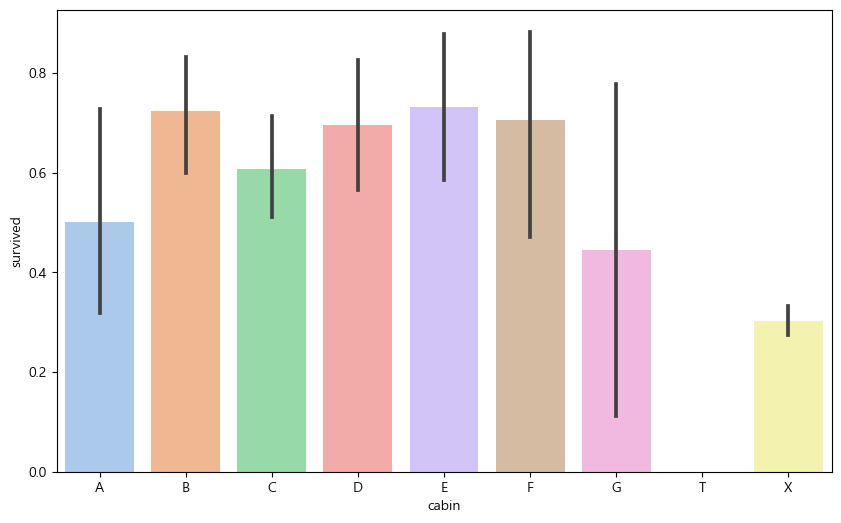

In [1827]:
# 객실 구역
plt.figure(figsize=(10,6))
order=['A','B','C','D','E','F','G','T','X']
sns.barplot(x='cabin',y='survived',order=order,data=df, palette='pastel')

<AxesSubplot:xlabel='cabin', ylabel='count'>

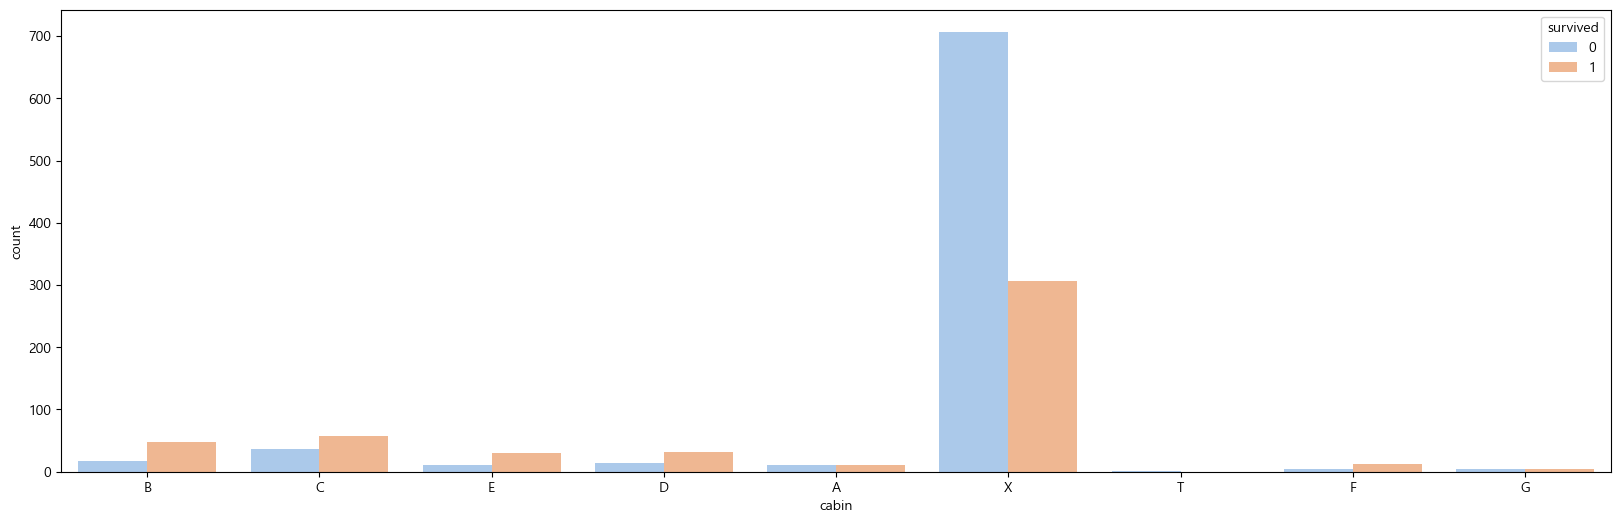

In [1828]:
plt.figure(figsize=(20,6))
sns.countplot(x='cabin',hue='survived',data=df, palette='pastel')

### 승선항에 따른 생존률

Text(1.0, 1.0, '승선항/객실등급 별 생존률')

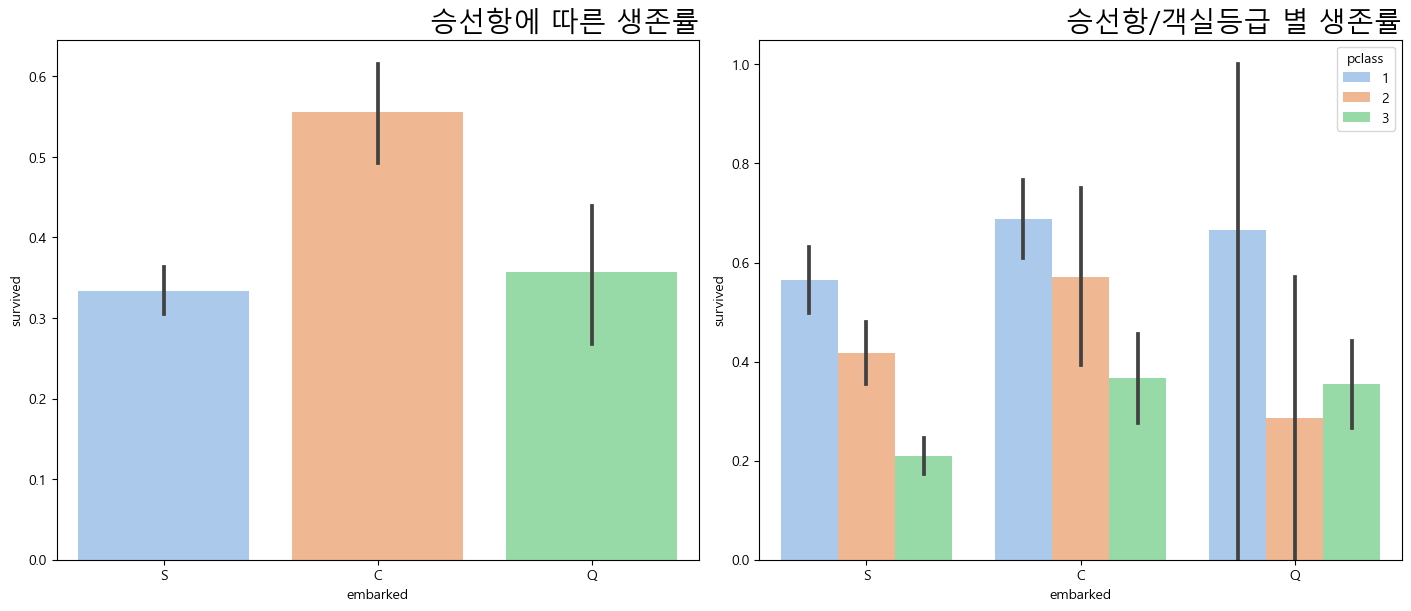

In [1826]:
# 승선항
fig, ax = plt.subplots(ncols=2, figsize=(14,6), constrained_layout=True)
sns.barplot(x='embarked',y='survived',data=df, ax=ax[0], palette='pastel')
sns.barplot(x='embarked',y='survived',hue='pclass',data=df, ax=ax[1], palette='pastel')

ax[0].set_title("승선항에 따른 생존률",loc='right',size=20)
ax[1].set_title("승선항/객실등급 별 생존률",loc='right',size=20)

# 1,2,3 등급 모두 통틀어 'C'항구의 생존률이 가장 높은 편

<AxesSubplot:xlabel='embarked', ylabel='count'>

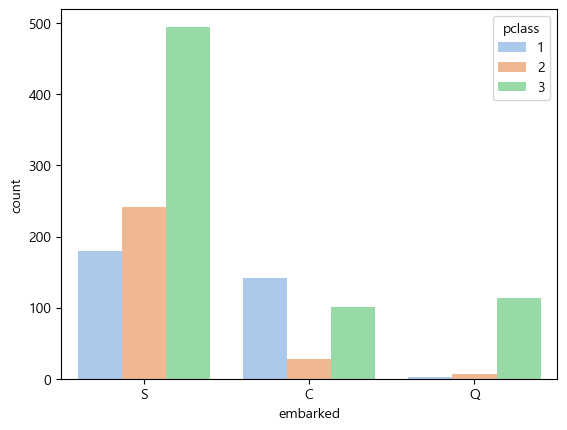

In [1825]:
sns.countplot(x='embarked',hue='pclass', data=df, palette='pastel')
# sns.countplot(x='embarked', data=df, palette='pastel')

# 생존률이 낮은 'S'와 'Q'항구는 3등급 객실 사람들이 많음
# 'C'항구의 경우 1등급 객실 사람들의 비율이 높은 편 (인원수도 S>C>Q)

### 동승 가족 수에 따른 생존률

Text(1.0, 1.0, '동승한 형제/배우자 수에 따른 생존률')

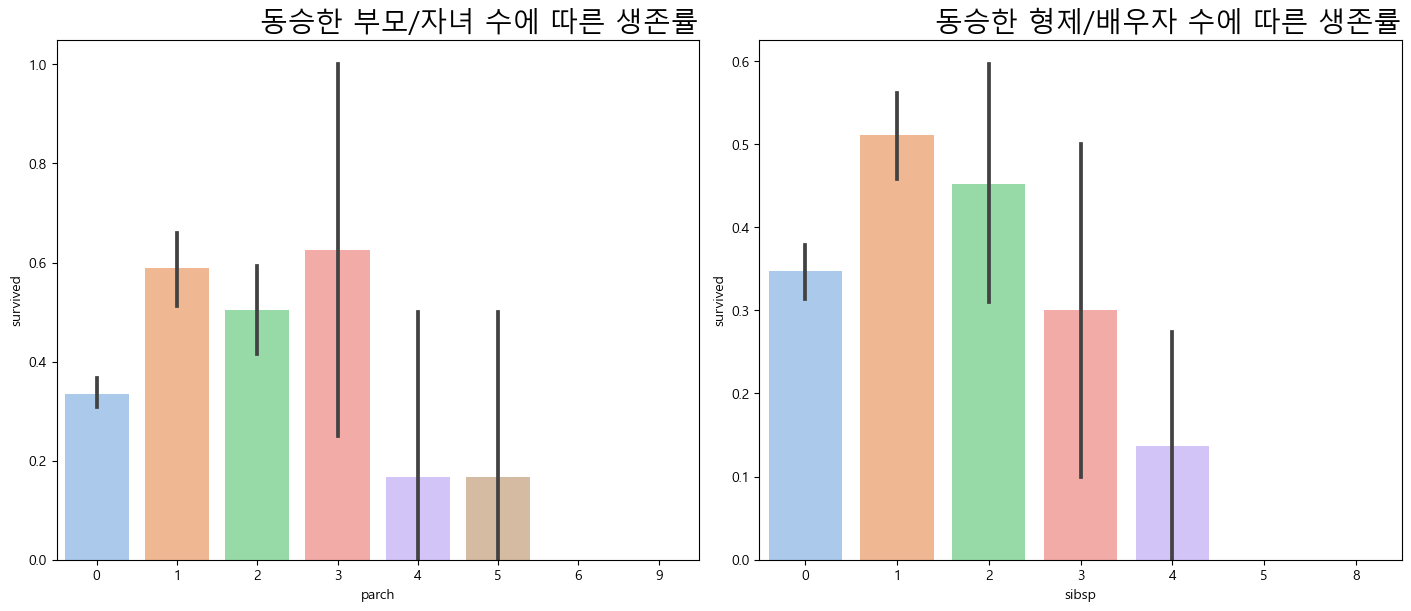

In [1824]:
# 동승한 부모 또는 자녀 수/ 형제 도는 배우자 수
fig, ax = plt.subplots(ncols=2, figsize=(14,6), constrained_layout=True)
sns.barplot(x='parch',y='survived',data=df, ax=ax[0], palette='pastel')
sns.barplot(x='sibsp',y='survived',data=df, ax=ax[1], palette='pastel')

ax[0].set_title("동승한 부모/자녀 수에 따른 생존률",loc='right',size=20)
ax[1].set_title("동승한 형제/배우자 수에 따른 생존률",loc='right',size=20)

# 아예 없는 것보단 가족과 함께 탔을 때가 더 생존률이 높음(1~3명)
# 그러나 4명 이상부턴 오히려 생존률이 떨어지는 편

Text(1.0, 1.0, '동승한 가족 수/객실 등급에 따른 생존률')

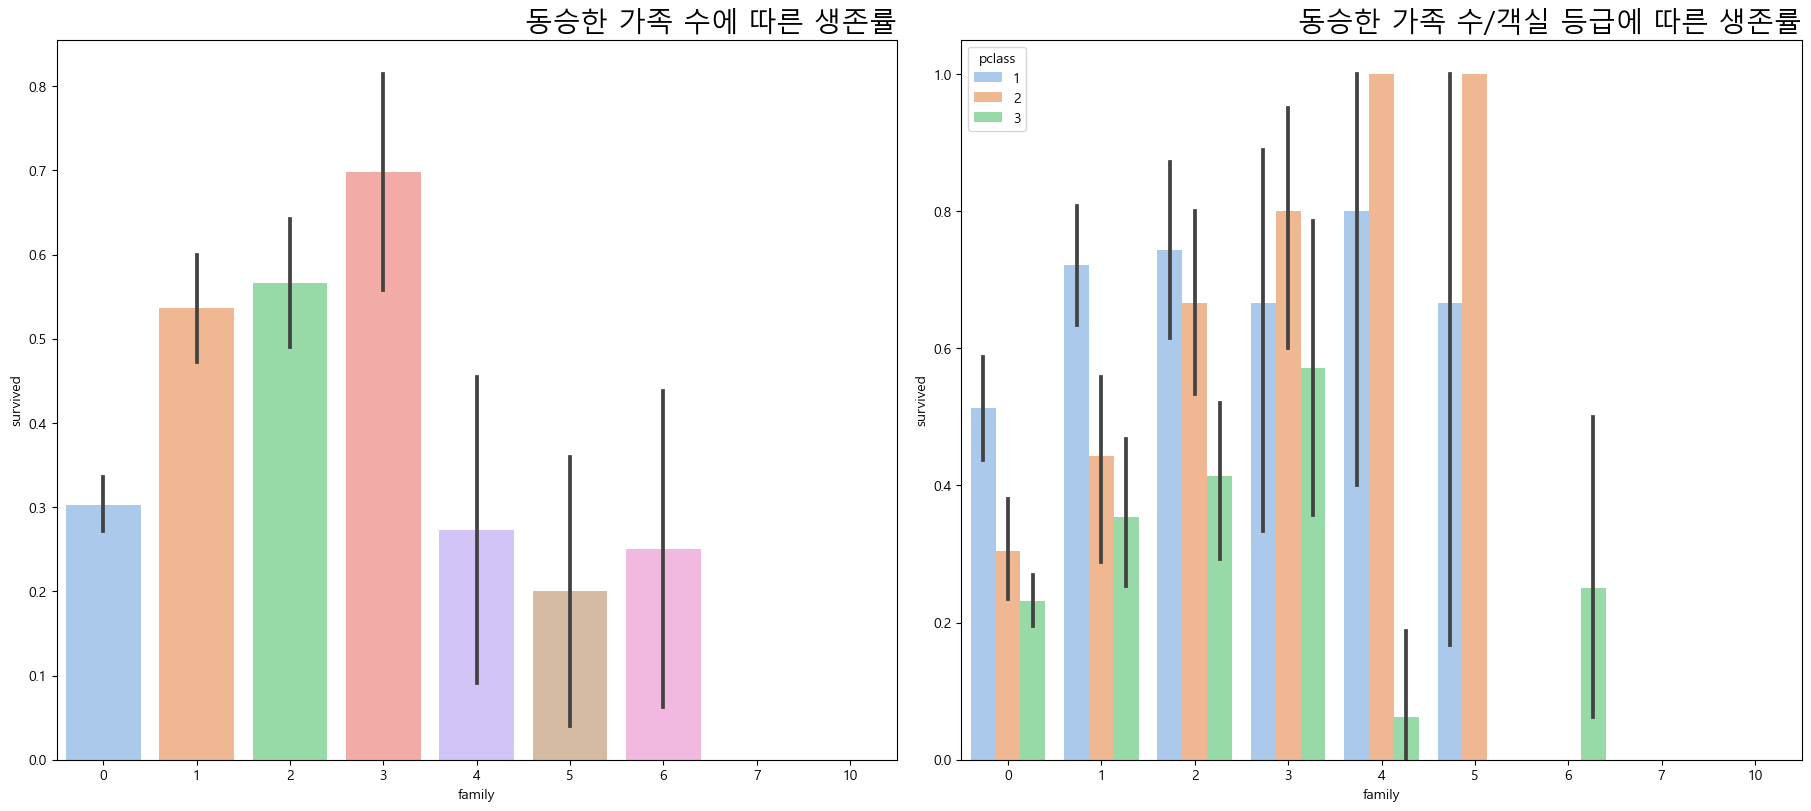

In [1823]:
# 동승한 부모, 자녀, 형제, 배우자 등 총합
fig, ax = plt.subplots(ncols=2, figsize=(18,8), constrained_layout=True)
sns.barplot(x='family',y='survived',data=df, ax=ax[0], palette='pastel')
sns.barplot(x='family',y='survived',hue='pclass',data=df, ax=ax[1], palette='pastel')

ax[0].set_title("동승한 가족 수에 따른 생존률",loc='right',size=20)
ax[1].set_title("동승한 가족 수/객실 등급에 따른 생존률",loc='right',size=20)

# 전체적으로 동승한 가족이 있을수록 생존률이 높아짐
# 다만 가족 수가 너무 많아도 생존률이 떨어지는 추세
# 4,5에서 전체 생존률에 비해 1/2등급의 생존률이 매우 높게 나온 것은 3등급에 비해 1/2등급 탑승자가 얼마 없어서

<AxesSubplot:xlabel='family', ylabel='survived'>

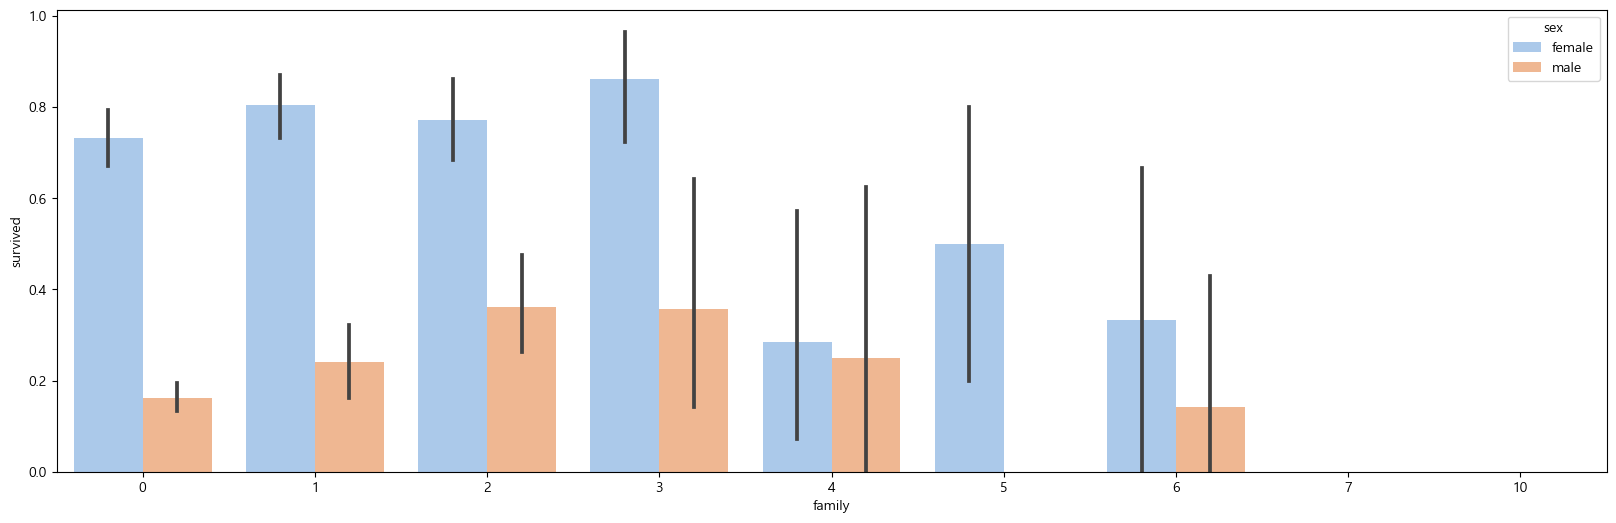

In [1822]:
plt.figure(figsize=(20,6))
sns.barplot(x='family',y='survived',hue='sex',data=df, palette='pastel')

<AxesSubplot:xlabel='family', ylabel='count'>

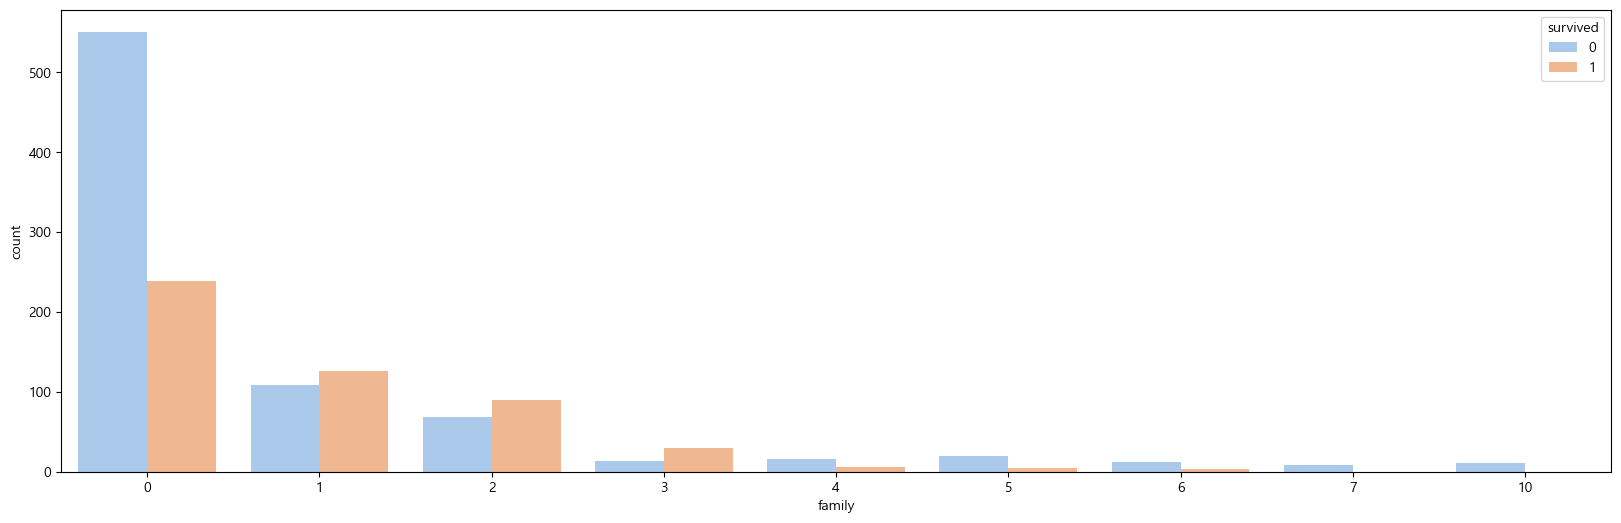

In [1821]:
plt.figure(figsize=(20,6))
sns.countplot(x='family',hue='survived',data=df, palette='pastel')

<AxesSubplot:xlabel='family', ylabel='count'>

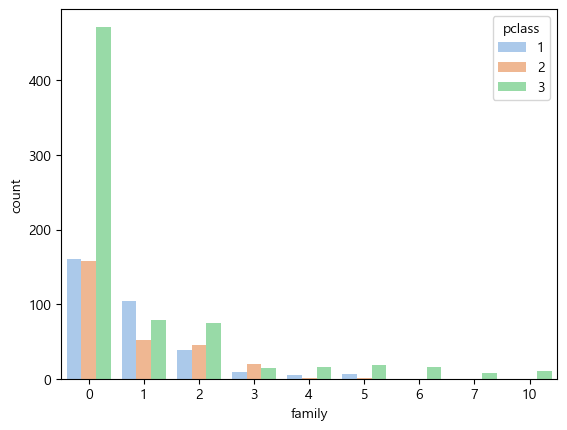

In [1820]:
sns.countplot(x='family',hue='pclass',data=df, palette='pastel')

### 객실 가격에 따른 생존률

Text(1.0, 1.0, '객실 등급에 따른 생존률')

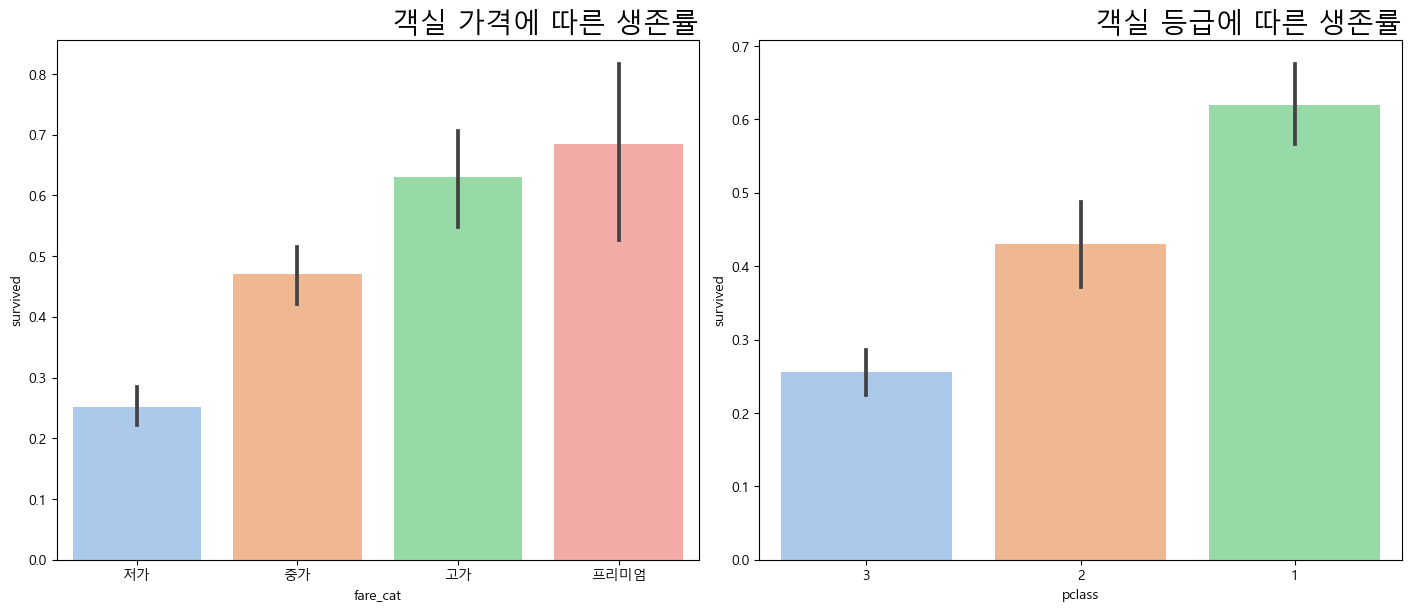

In [1819]:
# 가격에 따른 생존률
fig, ax = plt.subplots(ncols=2, figsize=(14,6), constrained_layout=True)

order=['저가','중가','고가','프리미엄']
sns.barplot(x='fare_cat',y='survived', order=order, data=df, palette='pastel', ax=ax[0])
order=[3,2,1]
sns.barplot(x='pclass',y='survived', order=order, data=df, palette='pastel', ax=ax[1])

ax[0].set_title("객실 가격에 따른 생존률",loc='right',size=20)
ax[1].set_title("객실 등급에 따른 생존률",loc='right',size=20)

# 비싼 객실에 묶고 있을 수록 생존률 높음
# 찾아보니 -> 당시 높은 등급 객실들의 위치가 탈출이 용이한 곳이었고, 
# 낮은 등급 객실 사람들이 나오지 못하게 바리게이트를 쳐 놔서 탈출이 늦어졌다고 함

<AxesSubplot:xlabel='fare_cat', ylabel='survived'>

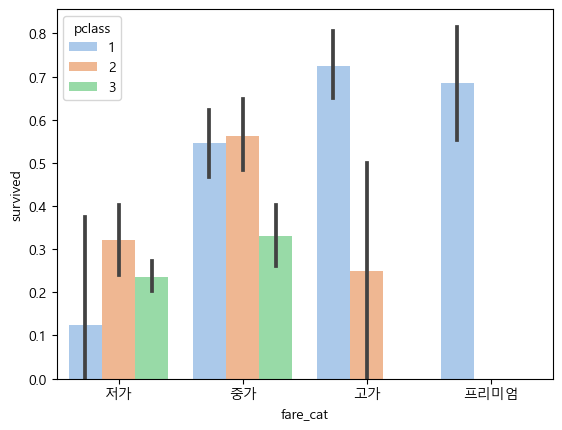

In [1818]:
# 가격/객실등급 별 생존률
order=['저가','중가','고가','프리미엄']
sns.barplot(x='fare_cat',y='survived', hue='pclass',order=order, palette='pastel', data=df)

### 직업(타이틀)에 따른 생존률

<AxesSubplot:xlabel='name_j', ylabel='survived'>

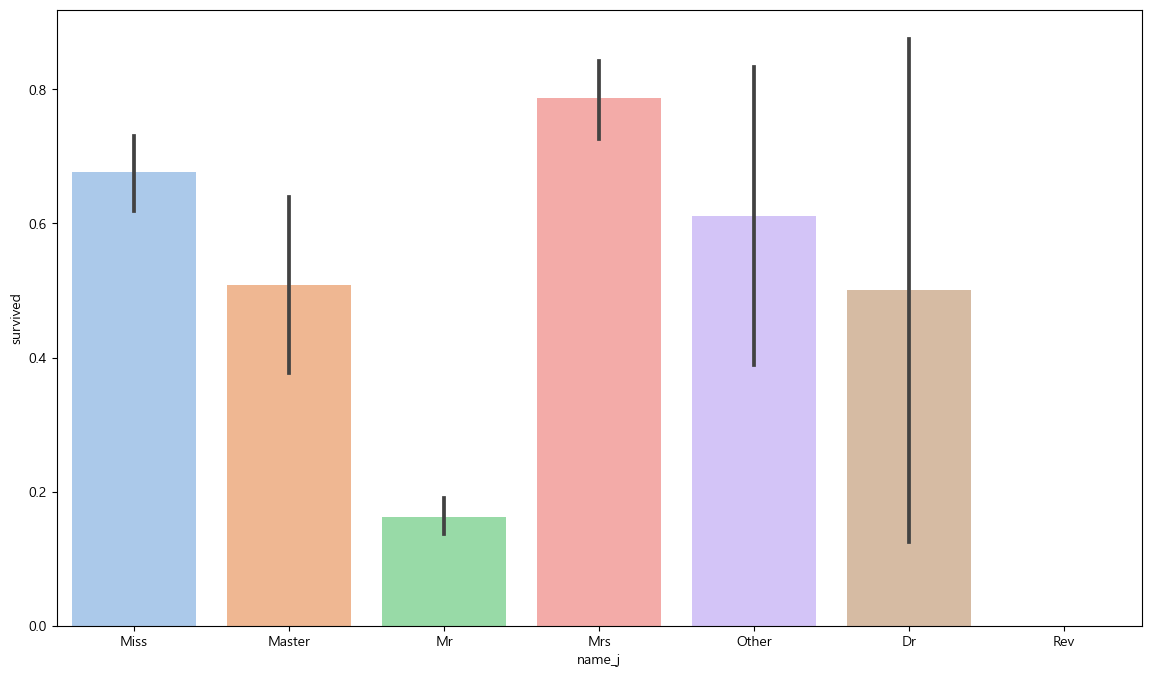

In [1817]:
#### 직업(타이틀)에 따른 생존률
plt.figure(figsize=(14,8))
order=['Miss', 'Master', 'Mr', 'Mrs', 'Other', 'Dr', 'Rev']
sns.barplot(x='name_j',y='survived',order=order,data=df, palette='pastel')

In [1788]:
#### 원핫 인코딩: 승선 항구
df = pd.get_dummies(df, columns=['embarked'])

#### 원핫 인코딩: 성별
df = pd.get_dummies(df, columns=['sex'])

#### 원핫 인코딩: 객실
# df = pd.get_dummies(df, columns=['cabin'])

#### 원핫 인코딩: 나이
df = pd.get_dummies(df, columns=['age_cat'])

#### 원핫 인코딩: 클래스
# df = pd.get_dummies(df, columns=['pclass'])

#### 원핫 인코딩: 가격
df = pd.get_dummies(df, columns=['fare_cat'])

#### 원핫 인코딩: 직업(타이틀)
df = pd.get_dummies(df, columns=['name_j'])

In [1789]:
# df.drop(['age', 'fare','fare_cat','cabin'], axis=1, inplace=True)
df.drop(['age', 'fare','pclass','cabin'], axis=1, inplace=True)

In [1790]:
df

,survived,sibsp,parch,family,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,age_cat_Adult,...,fare_cat_저가,fare_cat_중가,fare_cat_프리미엄,name_j_Dr,name_j_Master,name_j_Miss,name_j_Mr,name_j_Mrs,name_j_Other,name_j_Rev
0,1,0,0,0,0,0,1,1,0,1,...,0,0,1,0,0,1,0,0,0,0
1,1,1,2,3,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,0,1,2,3,0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,1,2,3,0,0,1,0,1,1,...,0,0,0,0,0,0,1,0,0,0
4,0,1,2,3,0,0,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0,1,0,1,1,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
1305,0,1,0,1,1,0,0,1,0,1,...,1,0,0,0,0,1,0,0,0,0
1306,0,0,0,0,1,0,0,0,1,1,...,1,0,0,0,0,0,1,0,0,0
1307,0,0,0,0,1,0,0,0,1,1,...,1,0,0,0,0,0,1,0,0,0


In [1791]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# 독립변수, 종속변수 분리
y_t_df = df['survived'] # 종속변수
X_t_df = df.drop('survived', axis = 1) # 독립변수

# 독립변수 정규화
# X_t_df = preprocessing.StandardScaler().fit(X_t_df).transform(X_t_df)

# 학습용 데이터와 평가용 데이터를 8:2 혹은 7:3으로 분리
X_train, X_test, y_train, y_test = train_test_split(X_t_df, y_t_df, test_size = 0.2,
                                                   random_state = 11)

print(X_train.shape)
print(X_test.shape)

(1047, 25)
(262, 25)


In [1792]:
# 모델 학습 및 평가
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, rf_pred).round(2)

lr_model = LogisticRegression()
lr_model.fit(X_train,y_train)
lr_pred = lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test,lr_pred).round(2)

print('rf 정확도:{}, lr 정확도:{}'.format(accuracy_rf,accuracy_lr))

rf 정확도:0.82, lr 정확도:0.84


# 인사이트 정리

1. 동승자 관련 생존률 -> 혼자보단 가족과 함께 탑승한 승객의 생존률이 높다.(단, 4명 이상부터는 오히려 떨어지는 편)
2. 승선지 관련 생존률 -> S, C, Q 승선지중 C(쉘부르크)가 가장 생존률이 높다.
- 사우스햄튼은 탑승자수가 가장 많고, 3등급 승객의 비율도 매우 높은 편
- 퀸즈타운은 탑승자 수는 적은 편이나, 비율적으로 3등급 승객이 거의 대부분을 차지함
- 쉘부르크는 1등급 승객의 비율이 가장 많음 -> 생존률 높음
3. 가격 관련 생존률 -> 가격/객실등급이 높을수록 생존률이 높다.
4. 성별 관련 생존률 -> 여성이 생존률이 높다.
5. 연령 관련 생존률 -> 아기, 아이들이 생존률이 높은데에 비해 노인들은 생존률이 낮다.
- Elder는 1등급 승객조차도 절반밖에 못 살음(다른 나이대 1등급에 비해 훨씬 낮은 수치)
- 23등급 전원 사망
- Old는 1등급 사람 비율이 워낙 많아서 생존률이 높게 나옴
- Old의 23등급 생존률만 떼어 놓고 보면 다른 그룹에 비해 낮은 편

< 추가적인 배경 설명 >
- 1912년 당시 여자와 아이가 우선되는 사회적인 분위기로 인한 결과.
- 타이타닉 사건때에는 승객들에 대한 승무원들의 통제도가 높았고, 승무원또한 상관에 대한 명령복종도가 높았음.
    => 상관의 원칙에 철저하게 따를 수 있었다.
- 타이타닉 사건 직전에 다른 배 침몰 사건(군인들이 민간인을 살리기 위해 희생한 사건)이 있어 희생정신이 부각되었다.
- 말을 듣지 않는 승객은 총으로 다스린 모양...
